In [1]:
!mkdir results
!pip install keras

    100% |████████████████████████████████| 327kB 2.2MB/s 


In [5]:
!wget https://raw.githubusercontent.com/AISaturdaysTaipei/fastai/master/images/bird.png
!wget https://raw.githubusercontent.com/AISaturdaysTaipei/fastai/master/images/starry-night.png
  

--2018-03-05 05:41:38--  https://raw.githubusercontent.com/AISaturdaysTaipei/fastai/master/images/bird.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176380 (172K) [image/png]
Saving to: ‘bird.png’

bird.png            100%[===================>] 172.25K  --.-KB/s    in 0.04s   

2018-03-05 05:41:38 (3.94 MB/s) - ‘bird.png’ saved [176380/176380]

--2018-03-05 05:41:39--  https://raw.githubusercontent.com/AISaturdaysTaipei/fastai/master/images/starry-night.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 281618 (275K) [image/png]
Savi

In [3]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fmin_l_bfgs_b

from scipy.misc import imsave  # `imsave` is deprecated! Use `imageio.imwrite`ß instead.
# from imageio import imwrite

import time
from keras.preprocessing.image import load_img, img_to_array 
from keras import backend as K
from keras import metrics
from keras.models import Model
from keras.applications import vgg16

Original content image


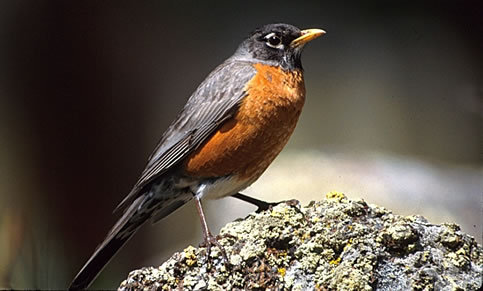

In [8]:
# This is the path to the image you want to transform.
content_img_path = 'bird.png'
# This is the path to the style image.
style_image_path = 'starry-night.png'

original_img = load_img(content_img_path)
width, height = original_img.size

print('Original content image')
original_img

Original Style image


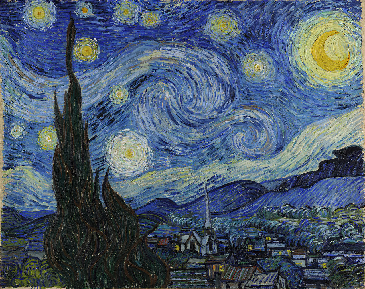

In [9]:
print('Original Style image')
load_img(style_image_path)

Resized content image


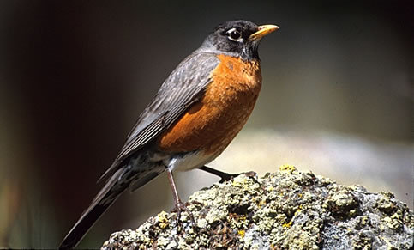

In [10]:
# 設定image的大小
img_height = 250

img_width = int(width * img_height / height)

resized_img = original_img.resize((img_width, img_height))

print('Resized content image')
resized_img

In [0]:
# 預處理image，得到image_arr, shape=(1,img_height, img_width, 3)
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_arr = img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = vgg16.preprocess_input(img_arr)
    return img_arr


# image送進vgg16之前要先normalize
# deprocess_image用來還原經過normalize的image
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x = x.copy()
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)
    

    
def solve_image(evaluator, iterations, x):
    for i in range(iterations):
        print('Start of iteration', i+1)
        start_time = time.time()
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                         fprime=evaluator.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        img = x.reshape((img_height, img_width, 3))
        img = deprocess_image(img)
        imsave(f'results/res_at_iteration_{i+1}.png', img)
        end_time = time.time()
        print(f'Iteration {i+1} completed in {int(end_time - start_time)}s')
    return x    

In [0]:
content_img_arr = preprocess_image(content_img_path)
style_image_arr = preprocess_image(style_image_path)
shp = content_img_arr.shape

In [14]:
model = vgg16.VGG16(include_top=False)
print('Model loaded.')

58892288/58889256 [==============================] - 1s 0us/step
Model loaded.


In [0]:
content_layer_name = 'block5_conv1'

content_layer = model.get_layer(content_layer_name).output
content_model = Model(model.input, content_layer)
targ = K.constant(content_model.predict(content_img_arr))

In [0]:
content_loss = K.mean(K.square(content_layer - targ))

grads = K.gradients(content_loss, content_model.input)
fn = K.function([content_model.input], [content_loss]+grads)
evaluator = Evaluator(fn, shp)

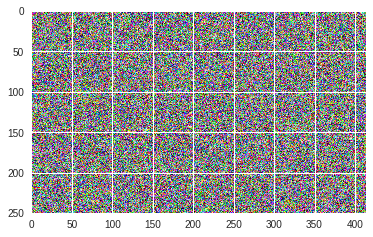

In [17]:
def rand_img(shape):
    return np.random.random(shape) * 20 + 128

x = rand_img(shp)
plt.imshow(x[0])
imsave('results/res_at_iteration_0.png', x[0])
x = vgg16.preprocess_input(x)

In [18]:
iterations=10

x = solve_image(evaluator, iterations, x)


Start of iteration 1
Current loss value: 825.788818359375
Iteration 1 completed in 3s
Start of iteration 2
Current loss value: 378.6827087402344
Iteration 2 completed in 2s
Start of iteration 3
Current loss value: 242.36695861816406
Iteration 3 completed in 2s
Start of iteration 4
Current loss value: 173.02841186523438
Iteration 4 completed in 2s
Start of iteration 5
Current loss value: 135.01971435546875
Iteration 5 completed in 2s
Start of iteration 6
Current loss value: 111.87026977539062
Iteration 6 completed in 2s
Start of iteration 7
Current loss value: 94.17498016357422
Iteration 7 completed in 2s
Start of iteration 8
Current loss value: 83.22213745117188
Iteration 8 completed in 2s
Start of iteration 9
Current loss value: 74.52794647216797
Iteration 9 completed in 2s
Start of iteration 10
Current loss value: 68.62419891357422
Iteration 10 completed in 2s


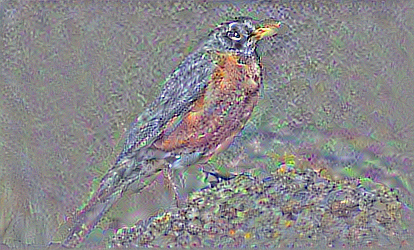

In [19]:
load_img(f'results/res_at_iteration_{iterations}.png')

In [0]:
def plot_images_labels(images, labels, height=15, idx=0, num=10):
    fig = plt.gcf()
    fig.set_size_inches(height, height*img_width // img_height)
    if num > 20: num = 20 
    for i in range(0, num):
        ax=plt.subplot(5, 3, i+1)
        ax.imshow(images[idx], cmap='binary')

        ax.set_title(f'{str(labels[idx])}', fontsize=10) 
        
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

In [0]:
images = []
labels = []
for i in range(iterations+1):
    img = load_img(f'results/res_at_iteration_{i}.png')
    images.append(np.array(img))
    labels.append(f'iteration_{i}')

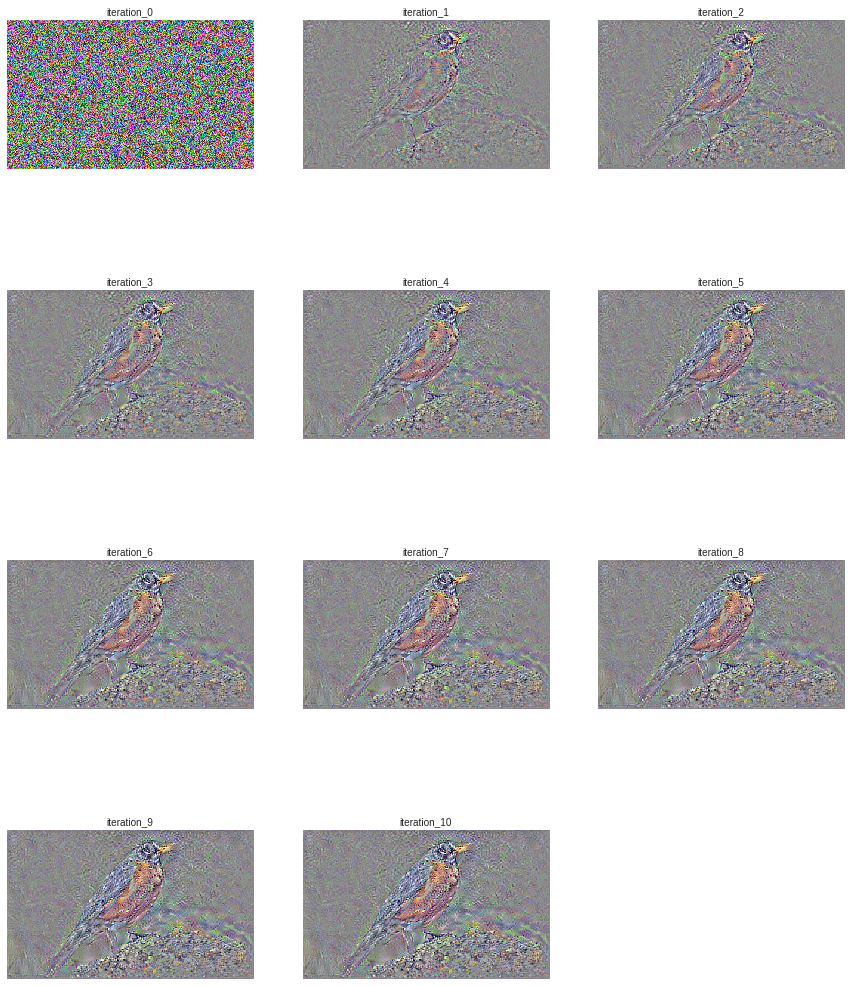

In [22]:
plot_images_labels(images, labels, num=iterations+1)


In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def one_layer_style_loss(x, targ):
    S = gram_matrix(targ)
    C = gram_matrix(x)
    channels = 3
    size = img_height * img_width
    return K.mean(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layers used for style loss
style_layer_names = ['block5_conv2', 'block5_conv3']
#                 'block2_conv1',
#                 'block3_conv1']

style_layers = [outputs_dict[l_name] for l_name in style_layer_names]

In [0]:
style_model = Model(model.input, style_layers)
targs = [K.constant(o) for o in style_model.predict(style_image_arr)]

In [0]:
style_loss = sum(one_layer_style_loss(l1[0], l2[0]) for l1,l2 in zip(style_layers, targs))
style_grads = K.gradients(style_loss, style_model.input)
style_fn = K.function([style_model.input], [style_loss]+style_grads)
style_evaluator = Evaluator(style_fn, shp)

In [0]:
x = rand_img(shp)
x = vgg16.preprocess_input(x)

In [74]:
x = solve_image(style_evaluator, iterations, x)

Start of iteration 1
Current loss value: 0.007955793291330338
Iteration 1 completed in 0s
Start of iteration 2
Current loss value: 0.007955793291330338
Iteration 2 completed in 0s
Start of iteration 3
Current loss value: 0.007955793291330338
Iteration 3 completed in 0s
Start of iteration 4
Current loss value: 0.007955793291330338
Iteration 4 completed in 0s
Start of iteration 5
Current loss value: 0.007955793291330338
Iteration 5 completed in 0s
Start of iteration 6
Current loss value: 0.007955793291330338
Iteration 6 completed in 0s
Start of iteration 7
Current loss value: 0.007955793291330338
Iteration 7 completed in 0s
Start of iteration 8
Current loss value: 0.007955793291330338
Iteration 8 completed in 0s
Start of iteration 9
Current loss value: 0.007955793291330338
Iteration 9 completed in 0s
Start of iteration 10
Current loss value: 0.007955793291330338
Iteration 10 completed in 0s
Start of iteration 11
Current loss value: 0.007955793291330338
Iteration 11 completed in 0s
Start 

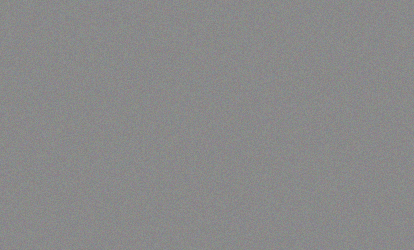

In [75]:
load_img(f'results/res_at_iteration_{iterations}.png')

In [0]:
transfer_loss = sum(one_layer_style_loss(l1[0], l2[0]) for l1,l2 in zip(style_layers, targs))
transfer_loss += 10*K.mean(K.square(content_layer - targ))

transfer_grads = K.gradients(transfer_loss, model.input)
transfer_fn = K.function([model.input], [transfer_loss]+transfer_grads)

In [0]:
transfer_evaluator = Evaluator(transfer_fn, shp)

In [0]:
iterations = 20
x = rand_img(shp)
x = vgg16.preprocess_input(x)

In [45]:
x = solve_image(transfer_evaluator, iterations, x)

Start of iteration 1
Current loss value: 391913.21875
Iteration 1 completed in 4s
Start of iteration 2
Current loss value: 97366.6875
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 40583.7734375
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 24857.345703125
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 18154.248046875
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 14396.9931640625
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 11887.2705078125
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 10433.458984375
Iteration 8 completed in 3s
Start of iteration 9
Current loss value: 9370.439453125
Iteration 9 completed in 3s
Start of iteration 10
Current loss value: 8539.974609375
Iteration 10 completed in 3s
Start of iteration 11
Current loss value: 7821.9091796875
Iteration 11 completed in 3s
Start of iteration 12
Current loss value: 7214.8388671875
Iteration 12 

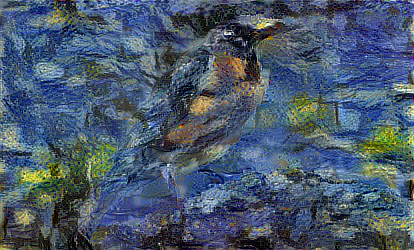

In [46]:
load_img(f'results/res_at_iteration_{iterations}.png')